# Running TARDIS with a Custom Packet Source

By default, TARDIS generates energy packets using its `BasePacketSource` class, which models the photosphere of the supernova as a perfect blackbody (see [Energy Packet Initialization](../../physics/montecarlo/initialization.ipynb)). However, users may create their own packet source, as will be shown in this notebook. In order to do this, a user must create a class (that can but does not have to inherit from `BasePacketSource`) which contains a method `create_packets` that takes in (in this order):
- the photospheric temperature
- the number of packets
- a random number generator
- the photospheric radius

and returns arrays of the radii, frequencies, propogation directions, and energies of the ensemble of packets (once again see [Energy Packet Initialization](../../physics/montecarlo/initialization.ipynb) for more information). To use your packet source in a run of TARDIS, you must pass an instance of your class into the `run_tardis` function under the `packet_source` keyword argument.

.. note:: In both the `BasePacketSource` class and in the example here, all packets are generated at the same radius. This need not be true in general (although the `create_packets` method should only take in a single radius as its argument).

We show an example of how a custom packet source is used:

In [1]:
# Import necessary packages
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.montecarlo.packet_source import BasePacketSource
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

/usr/share/miniconda3/envs/tardis/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


/usr/share/miniconda3/envs/tardis/lib/python3.7/site-packages/traitlets/traitlets.py:3050: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  FutureWarning,


In [2]:
# Download the atomic data used for a run of TARDIS
download_atom_data('kurucz_cd23_chianti_H_He')

In [3]:
# Create a packet source class that contains a create_packets method
class TruncBlackbodySource(BasePacketSource):
    """
        Custom inner boundary source class to replace the Blackbody source
        with a truncated Blackbody source.
    """
    
    def __init__(self, seed, truncation_wavelength):
        super().__init__(seed)
        self.rng = np.random.default_rng(seed=seed)
        self.truncation_wavelength = truncation_wavelength
    
    def create_packets(self, T, no_of_packets, rng, radius,
                       drawing_sample_size=None):
        """
        Packet source that generates a truncated Blackbody source.
        
        Parameters
        ----------
        T : float
            Blackbody temperature
        no_of_packets : int
            number of packets to be created
        truncation_wavelength : float
            truncation wavelength in Angstrom. 
            Only wavelengths higher than the truncation wavelength
            will be sampled.
        """
        
        # Makes uniform array of packet radii
        radii = np.ones(no_of_packets) * radius

        # Use mus and energies from normal blackbody source.
        mus = self.create_zero_limb_darkening_packet_mus(no_of_packets, self.rng)
        energies = self.create_uniform_packet_energies(no_of_packets, self.rng)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = u.Quantity(self.truncation_wavelength, u.Angstrom).to(
                                          u.Hz, equivalencies=u.spectral()).value
        
        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_blackbody_packet_nus(T, drawing_sample_size, self.rng)
        nus = nus[nus<truncation_frequency][:no_of_packets]
        
        
        # Only required if the truncation wavelength is too big compared to the maximum 
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_blackbody_packet_nus(
                T, drawing_sample_size, self.rng
            )
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]
            
        return radii, nus, mus, energies

In [4]:
# Call an instance of the packet source class
packet_source = TruncBlackbodySource(
    53253, truncation_wavelength=2000
)

We now run TARDIS both with and without our custom packet source, and we compare the results:

In [5]:
mdl = run_tardis('tardis_example.yml',
                 packet_source=packet_source)
mdl_norm = run_tardis('tardis_example.yml')

[py.warnings         ][WARNING]  /usr/share/miniconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (si.m, si.Hz, lambda x: _si.c.value / x),
 (warnings.py:110)


    'data': [{'type': 'scatter', 'uid': '5832fbd3-c2e4-4cfd-855b-42ee6fe5aa41', …

[py.warnings         ][WARNING]  /usr/share/miniconda3/envs/tardis/lib/python3.7/site-packages/astropy/units/equivalencies.py:124: RuntimeWarning:

divide by zero encountered in double_scalars

 (warnings.py:110)


    'data': [{'type': 'scatter', 'uid': '88562bd7-6014-43fd-a6a3-491f7e8798f8', …

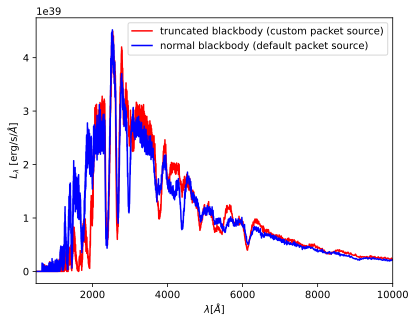

In [6]:
%matplotlib inline
plt.plot(mdl.runner.spectrum_virtual.wavelength,
         mdl.runner.spectrum_virtual.luminosity_density_lambda,
         color='red', label='truncated blackbody (custom packet source)')
plt.plot(mdl_norm.runner.spectrum_virtual.wavelength,
         mdl_norm.runner.spectrum_virtual.luminosity_density_lambda,
         color='blue', label='normal blackbody (default packet source)')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()